In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

## Data Preparation

In [2]:
# Load dataframes from pickle file
with open('../data/data_full.pkl', 'rb') as f:
    data, data_norm = pickle.load(f)

In [3]:
def is_outlier(data, rolling_median, thresh):
    if not pd.isna(rolling_median):
        return abs(data - rolling_median) >= thresh

In [4]:
# Remove outliers/point anomalies
data_nrm5 = data_norm.rolling(5, center=True).median()
data_nc = data_norm.copy()
s = data_nc.shape
for j in range(s[1]):
    for i in range(s[0]):
        if is_outlier(data_nc.iloc[i, j], data_nrm5.iloc[i, j], 0.2):
            data_nc.iloc[i, j] = data_nrm5.iloc[i, j]

In [5]:
# Calculate the first 3 principal components of data_norm
pca = PCA(n_components=3)
data_pca3 = pca.fit_transform(data_nc)
data_pca3 = pd.DataFrame(data_pca3, columns=['PC1', 'PC2', 'PC3'])

## KMeans

In [6]:
# Run k-means algorithm using cluster centers from 1 to 20 
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_nc)
    sse.append(kmeans.inertia_)

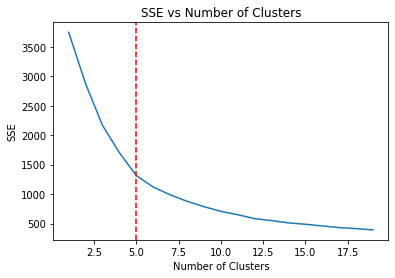

In [7]:
# Use the elbow method to determine the good number of clusters. In this case, it's 5
plt.plot(range(1, 20), sse)
plt.axvline(5, linestyle='--', c='red')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('SSE vs Number of Clusters')
plt.show()

In [8]:
# Rerun the K-means using 5 cluster centers
kmeans = KMeans(n_clusters=5, random_state=30)
labels = kmeans.fit_predict(data_nc)
data_pca3['label_kmean'] = labels

/Users/Zhou/anaconda3/envs/lab/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


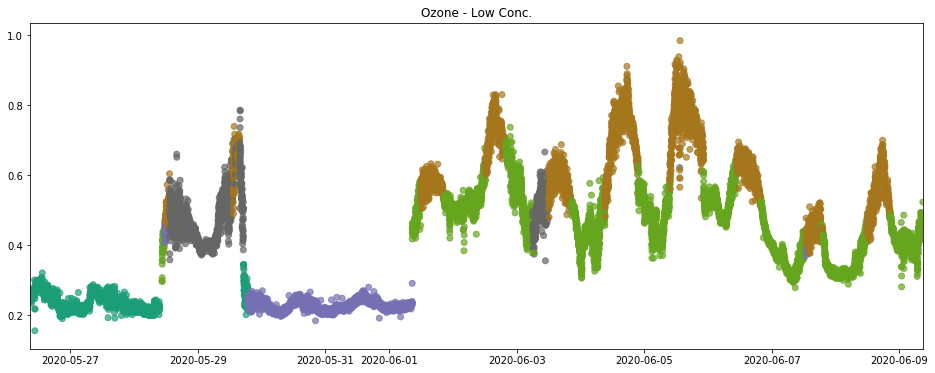

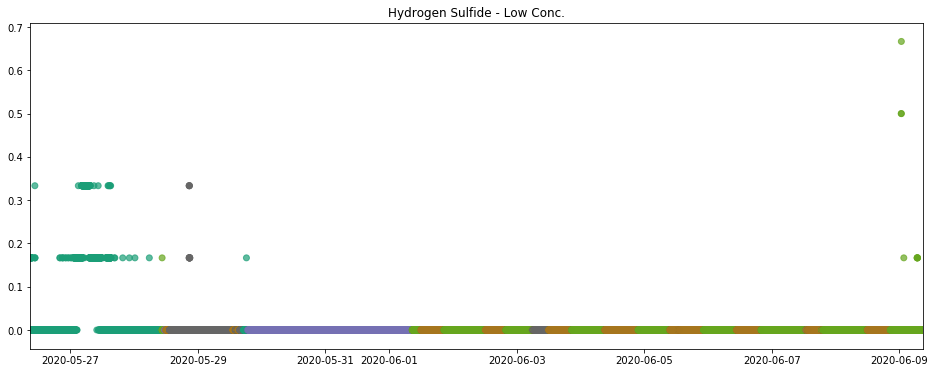

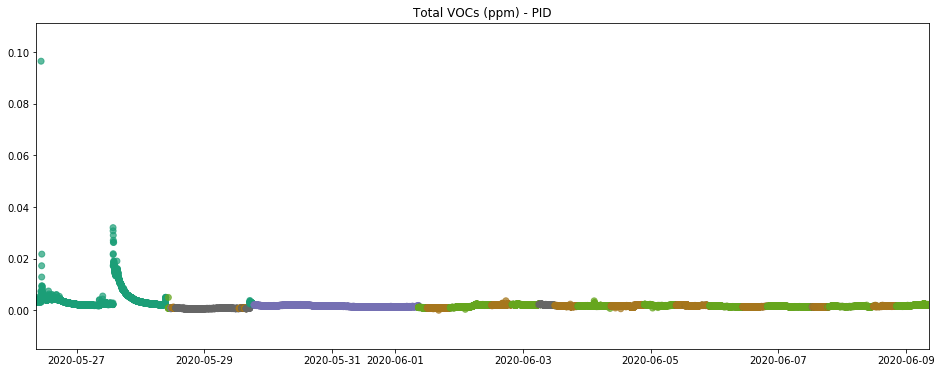

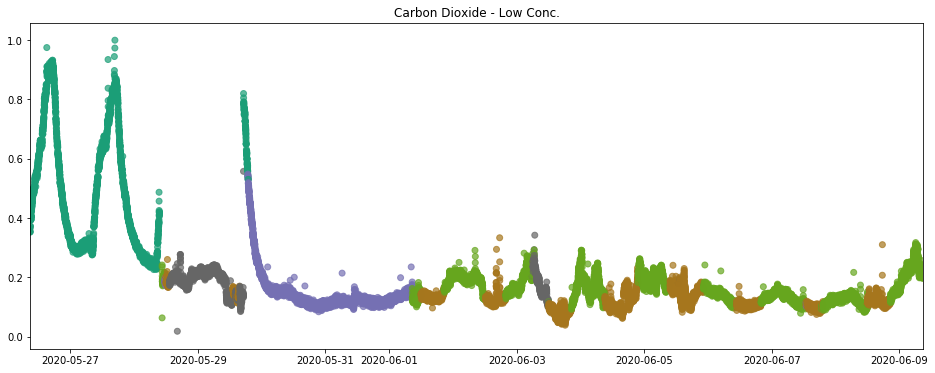

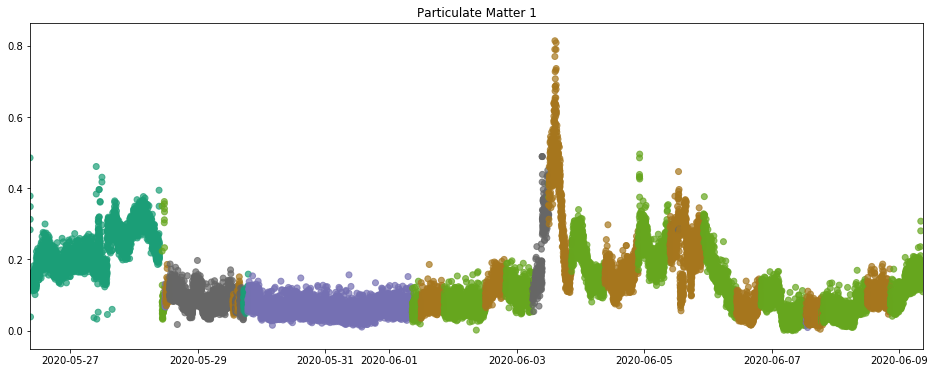

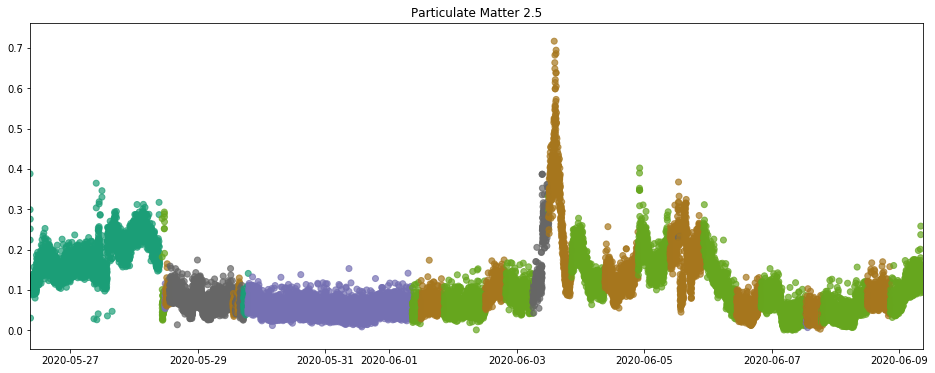

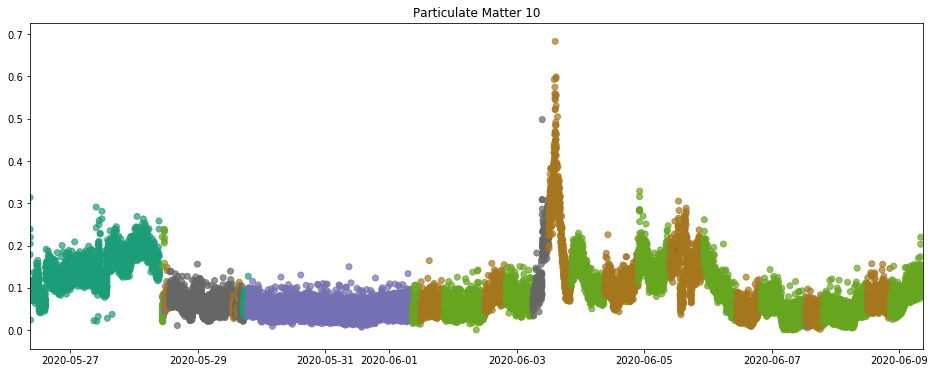

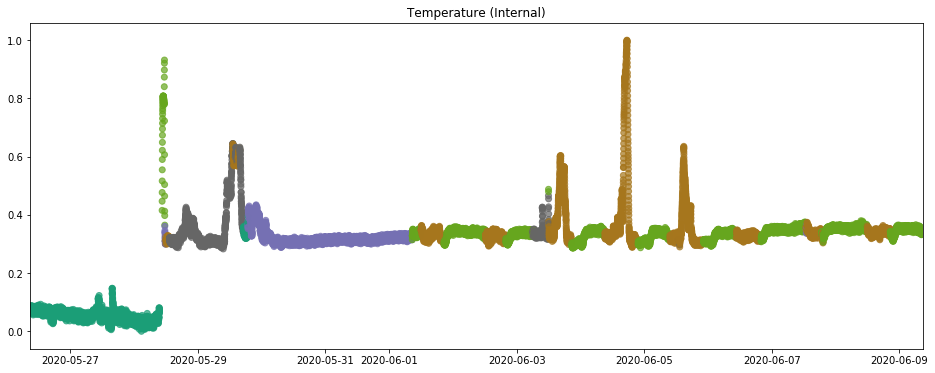

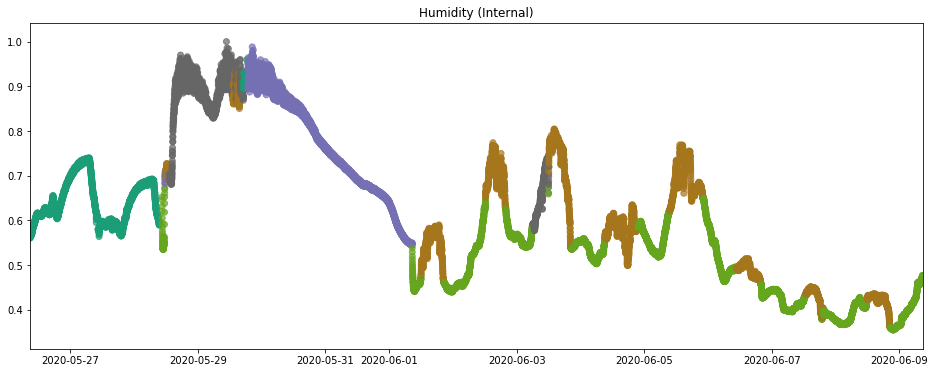

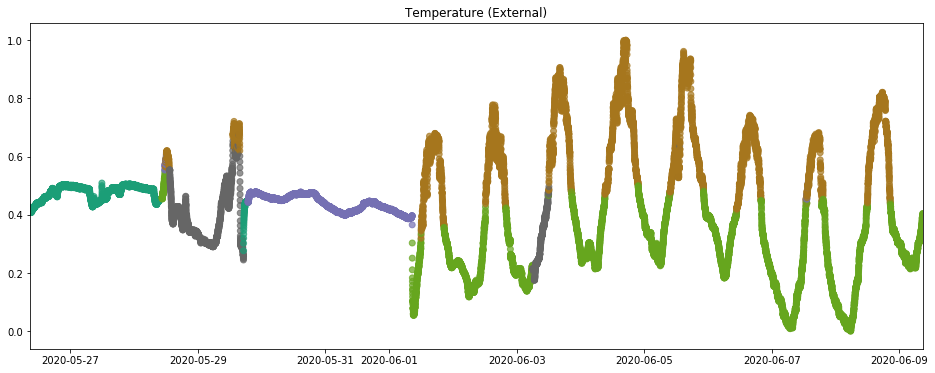

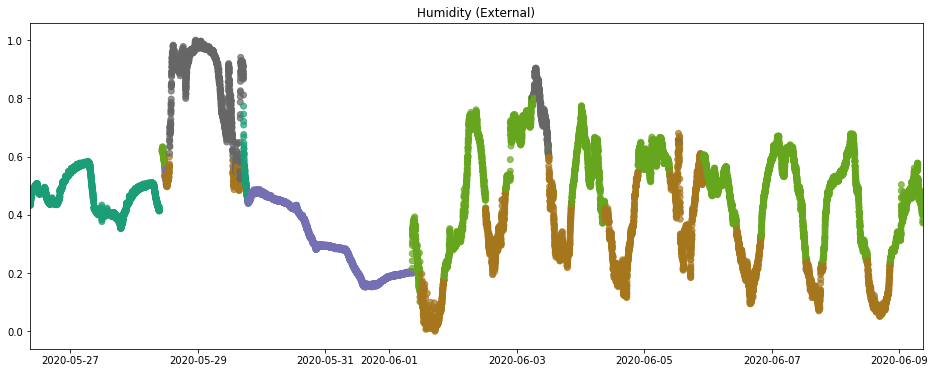

In [9]:
# Plot each of the time series with labeled clusters
for col in data.columns:
    fig, ax = plt.subplots(figsize=(16, 6))
    scatter = plt.scatter(data_nc.index, data_nc[col], c=labels, cmap=plt.get_cmap('Dark2'), alpha=0.7)
    plt.xlim([data.index[0], data.index[-1]])
    plt.title(col)
    plt.show()

## DBSCAN

In [10]:
# Run the DBSCAN algorithm
dbscan = DBSCAN(eps=0.14, min_samples=5)
labels = dbscan.fit_predict(data_norm)
data_pca3['label_DBSCAN'] = labels

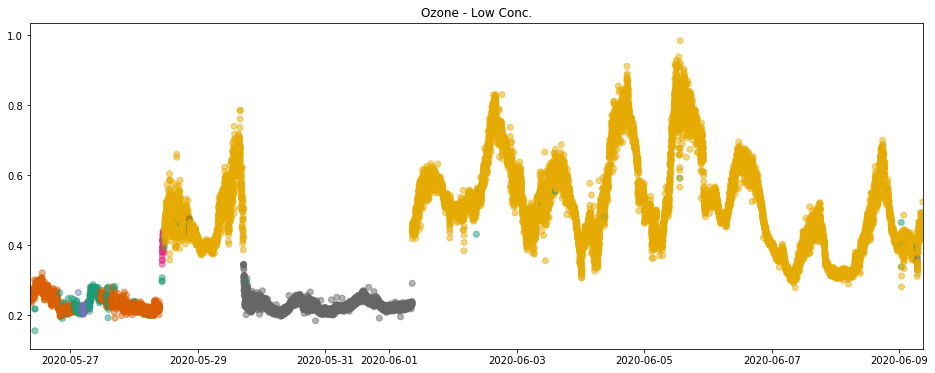

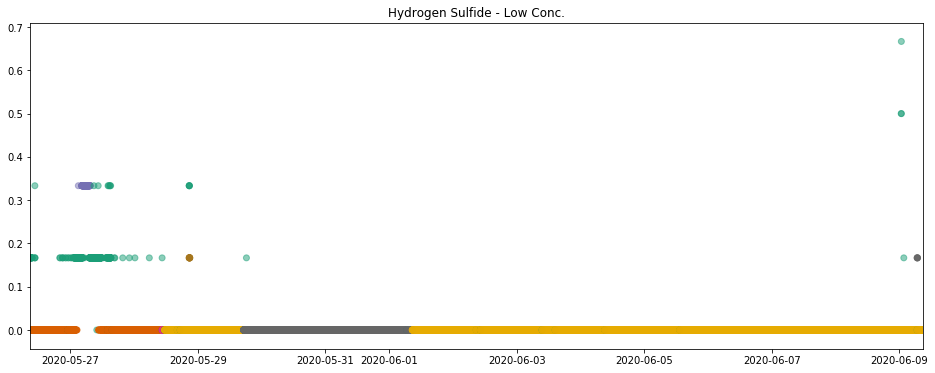

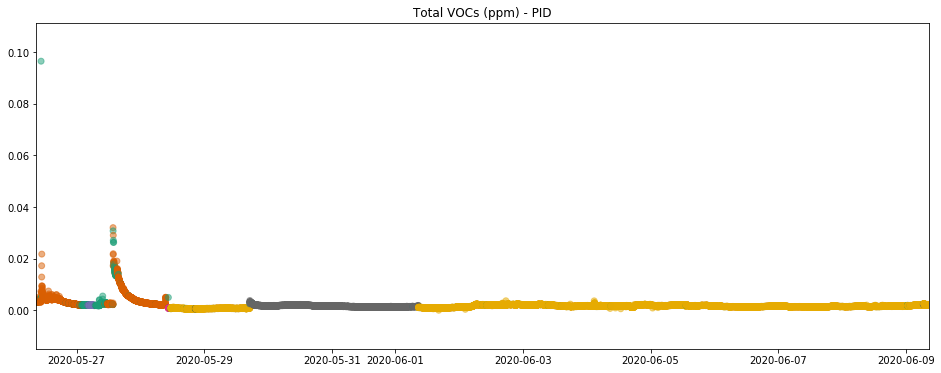

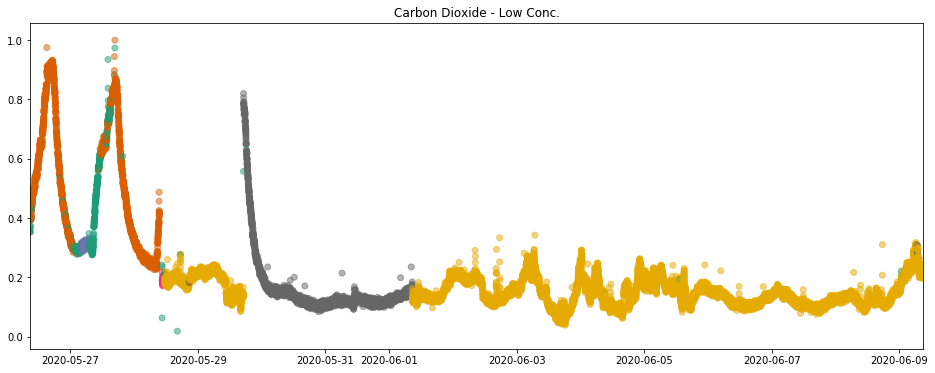

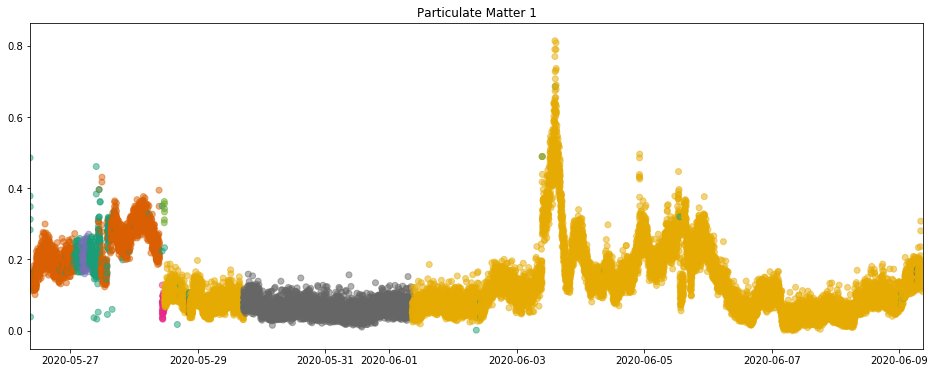

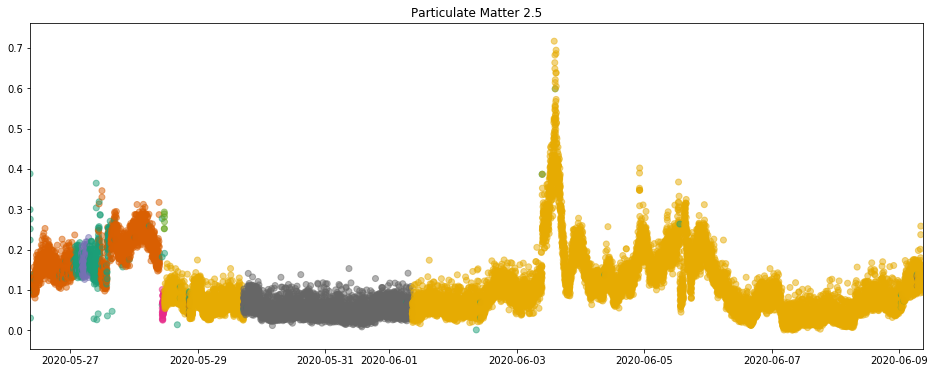

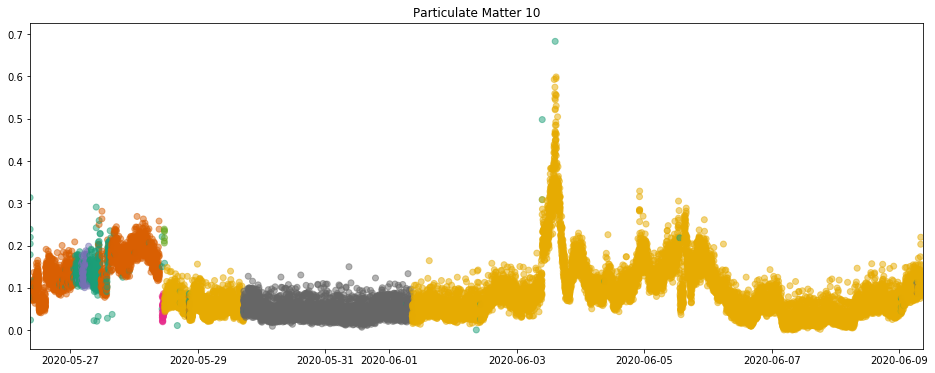

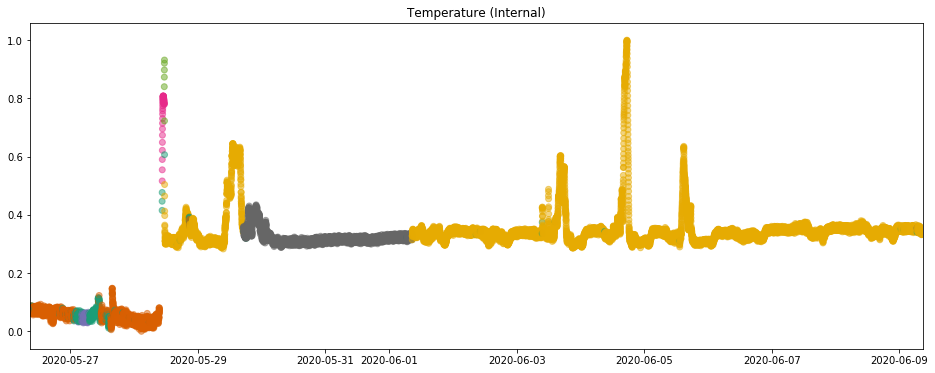

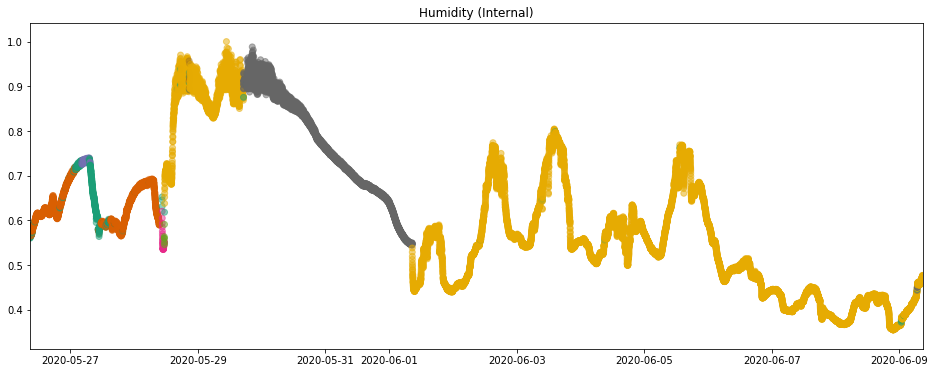

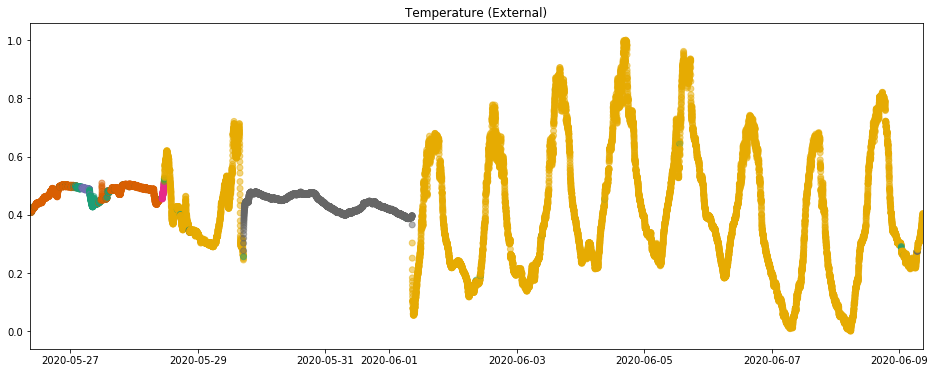

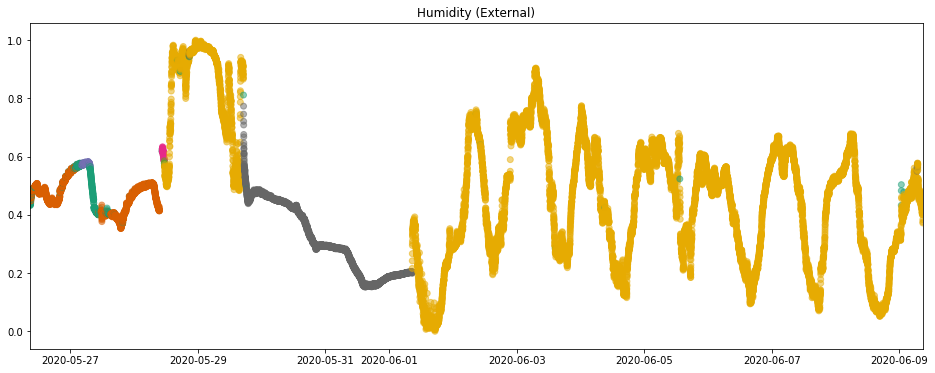

In [11]:
# Plot each of the time series with labeled clusters
for col in data_nc.columns:
    fig, ax = plt.subplots(figsize=(16, 6))
    plt.scatter(data_nc.index, data_nc[col], c=labels, alpha=0.5, cmap=plt.get_cmap('Dark2'))
    plt.xlim([data_nc.index[0], data_nc.index[-1]])
    plt.title(col)
    plt.show()

## Visualize and Compare

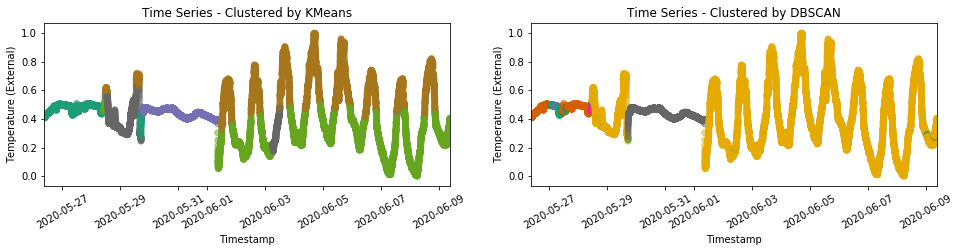

In [12]:
# Plot the Temperature (External) time series side by side
tick = ax.get_xticklabels()
fig, axs = plt.subplots(1, 2, figsize=(16, 3))
labels = [data_pca3['label_kmean'], data_pca3['label_DBSCAN']]
titles = ['Time Series - Clustered by KMeans', 'Time Series - Clustered by DBSCAN']
for i in range(2):
    scatter = axs[i].scatter(data_nc.index, data_nc['Temperature (External)'], c=labels[i], 
                      alpha=0.5, cmap=plt.get_cmap('Dark2'))
    axs[i].set_xlim([data_nc.index[0], data_nc.index[-1]])
    axs[i].set_xticklabels(tick, rotation=30)
    axs[i].set_xlabel('Timestamp')
    axs[i].set_ylabel('Temperature (External)')
    axs[i].set_title(titles[i])
plt.show()

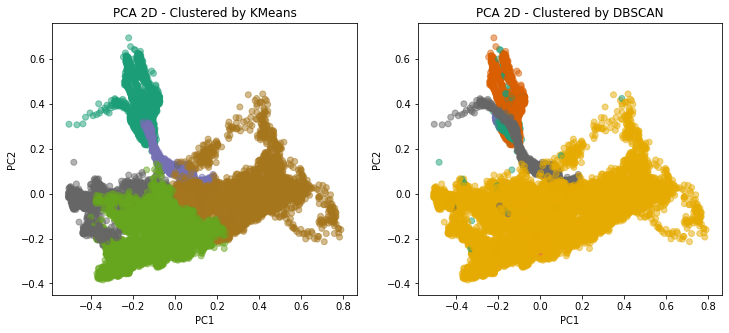

In [13]:
# Scatter plot of first 2 PCs
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
labels = [data_pca3['label_kmean'], data_pca3['label_DBSCAN']]
titles = ['PCA 2D - Clustered by KMeans', 'PCA 2D - Clustered by DBSCAN']
for i in range(2):
    axs[i].scatter(data_pca3['PC1'], data_pca3['PC2'], c=labels[i], 
                      alpha=0.5, cmap=plt.get_cmap('Dark2'))
    axs[i].set_xlabel('PC1')
    axs[i].set_ylabel('PC2')
    axs[i].set_title(titles[i])
plt.show()

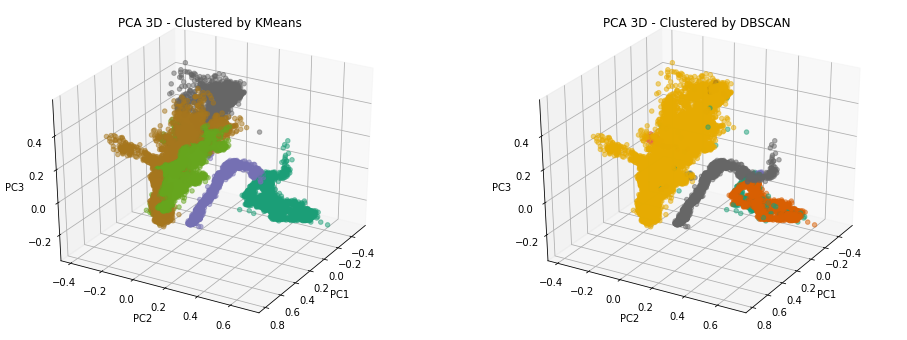

In [14]:
# Scatter plot of first 3 PCs
fig = plt.figure(figsize=(16, 6))
labels = [data_pca3['label_kmean'], data_pca3['label_DBSCAN']]
titles = ['PCA 3D - Clustered by KMeans', 'PCA 3D - Clustered by DBSCAN']

for i in range(2):
    ax = fig.add_subplot(1, 2, i+1, projection="3d")
    ax.scatter3D(data_pca3['PC1'], data_pca3['PC2'], data_pca3['PC3'], c=labels[i], 
                      alpha=0.5, cmap=plt.get_cmap('Dark2'))
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(titles[i])
    ax.view_init(30, 30)
plt.show()